# Relax Inc Challenge

## Table of Contents 
1. Load Packages and Data
    * packages
    * data

2. Identify Adopted Users 
    * create adopted users factor
    * explore data   

3. Identify factors predicting user adoption
    * correlation coefficients
    * downselection 

4. Preliminary Model
    * model creation
    * model accuracy

5. Summary and Conclusions
    * watermark

## Load Packages and Data

In [219]:
# accessing directory and os settings
import os
import sys 

# handling for and manipulation of arrays and dataframes
import numpy as np
import pandas as pd

# handling json files/data
import json

# data and time handling
import time
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# use os to get path
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

C:\Users\Hailey\Documents\GitHub\CodingChallenges


In [185]:
# set data paths
users_path = os.path.join(PROJ_ROOT, 'RelaxIncChallenge', 'data', 'takehome_users.csv')
user_engagement_path = os.path.join(PROJ_ROOT, 'RelaxIncChallenge', 'data', 'takehome_user_engagement.csv')

# read in data
users = pd.read_csv(users_path, encoding = "ISO-8859-1")
user_eng = pd.read_csv(user_engagement_path, encoding = "ISO-8859-1")

In [186]:
# set index
users.set_index('object_id', inplace=True)
# set features to proper type
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype('bool')
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype('bool')


users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,True,False,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,False,False,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,False,False,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,False,False,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,False,False,193,5240.0


In [187]:
# set index 
user_eng.index = user_eng['time_stamp']
# set time_stamp to datetime format
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

user_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3+ MB


In [188]:
# check for any null values
print(users.isnull().sum())
print(user_eng.isnull().sum())

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64
time_stamp    0
user_id       0
visited       0
dtype: int64


Above we imported essential packages and the project data, setting the index appropriately for each.  Next, we will investigate the user engagement data to find `adopted users`.

## Identify Adopted Users
i.e. Someone who has logged into the product on three separate days in seven day period

In [189]:
# create function to check for adopted users
def adoptedUser(df, days=7, logins=3):
    # create date column from timestamp and sort
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # days for logins
    days_passed = df['date'].diff(periods=logins-1)
    # give results for <= days
    return any(days_passed <= datetime.timedelta(days=days))

In [190]:
adopted_user = user_eng.groupby('user_id').apply(adoptedUser)
adopted_user

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Length: 8823, dtype: bool

In [191]:
print('There were {} adopted users out of the {} total users'.format(
    sum(adopted_user), len(adopted_user)))

There were 1656 adopted users out of the 8823 total users


## Identify factors predicting user adoption
Now that we have found our adopted users, we will look at features that are likely to predict a user becoming an adopted user.  Based on an initial understanding of the features, there are some likely to be well-correlated with user adoption, such as, opted_in_to_mailing_list, enabled_for_marketing_drip, and creation_source.  These factors are intuitively likely since being on a mailing list or participating in marketing email would capture the user's attention regularly.  The creation source could indicate users more apt to check regularly if, for example, they are invested in a personal project or a particular organization.  

In [192]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   float64       
 5   opted_in_to_mailing_list    12000 non-null  bool          
 6   enabled_for_marketing_drip  12000 non-null  bool          
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 773.4+ KB


There are some features we could engineer from features that seem unuseful in order to understand how long a user has had an account and how long the user has actively been using the account.

In [193]:
# drop features that are different for most entires and don't give valuable info
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [194]:
# perform feature engineering from creation_time and last_session_creation_time
# create a feature of user history
# convert both time features into datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')

# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

# calculate account age, defined as number of days since account creation and now
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [195]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        12000 non-null  object 
 1   email                       12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   opted_in_to_mailing_list    12000 non-null  bool   
 4   enabled_for_marketing_drip  12000 non-null  bool   
 5   history                     8823 non-null   float64
 6   account_age                 12000 non-null  int64  
dtypes: bool(2), float64(1), int64(1), object(3)
memory usage: 585.9+ KB


Drop users with zero history as they will not be very informative.

In [196]:
# merge user data and adopted user variable
#adopted_user = pd.DataFrame(adopted_user)
users.index.name = 'user_id'
data = pd.concat([users, adopted_user], axis=1, join='inner')
data.rename(columns = {0:'adopted_user'}, inplace =True)
data['adopted_user'] = data['adopted_user'].astype(int)
data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age,adopted_user
user_id,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,True,False,0.0,38,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,False,False,136.0,196,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,False,False,0.0,437,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,False,False,1.0,374,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,False,False,5.0,498,0


Visualize our featues.

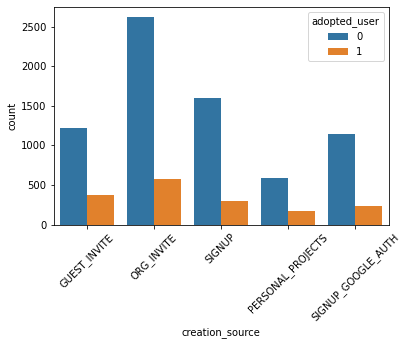

In [197]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=45)

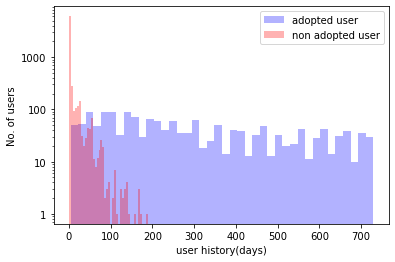

In [198]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=40, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=40, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
    
plot_hist_days(data, 'history', 'user history(days)')

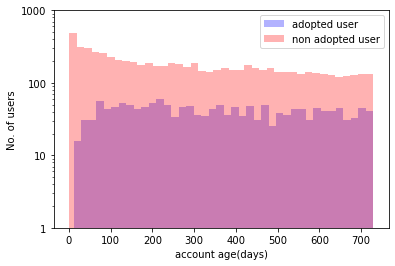

In [199]:
plot_hist_days(data, 'account_age', 'account age(days)')

Above we can see that some creation sources have slightly higher adoption.  We also see that adoption rate is lower in new accounts.  Interestingly, from the plot, it is not clear that history alters adoption.  

## Preliminary model
We are now ready to create our preliminary model.  The data will be split and fit to the model.  In this case no scaling will be needed because a random forest model will be used and this model is not affected by scale.  The model will be tested for accuracy to show that the features selected have good predictive ability.  

In [222]:
# one hot encode features, as approptiate
data = pd.get_dummies(data, columns = ['creation_source', 'opted_in_to_mailing_list',
                                           'enabled_for_marketing_drip'])
data.head()

,name,email,history,account_age,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_False,opted_in_to_mailing_list_True,enabled_for_marketing_drip_False,enabled_for_marketing_drip_True
user_id,,,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,0.0,38,0,1,0,0,0,0,0,1,1,0
2,Poole Matthew,MatthewPoole@gustr.com,136.0,196,1,0,1,0,0,0,1,0,1,0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,0.0,437,0,0,1,0,0,0,1,0,1,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,1.0,374,0,1,0,0,0,0,1,0,1,0
5,Raw Grace,GraceRaw@yahoo.com,5.0,498,0,1,0,0,0,0,1,0,1,0


In [218]:
# utilize customary notation
y = data['adopted_user']
X = data.drop(['adopted_user', 'name', 'email'], axis = 1)

# train and test sets 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=0)


# use random forest model with balanced class weights to correct for imbalance in the data
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.9616150924955413


In [220]:
# evluation of the model
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9578422484134179
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1792
           1       0.90      0.87      0.89       414

    accuracy                           0.96      2206
   macro avg       0.93      0.93      0.93      2206
weighted avg       0.96      0.96      0.96      2206



In [221]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                               0.891793
account_age                           0.090857
creation_source_GUEST_INVITE          0.002986
creation_source_SIGNUP                0.002378
creation_source_SIGNUP_GOOGLE_AUTH    0.002144
creation_source_ORG_INVITE            0.002017
opted_in_to_mailing_list_False        0.001835
creation_source_PERSONAL_PROJECTS     0.001795
opted_in_to_mailing_list_True         0.001635
enabled_for_marketing_drip_False      0.001458
enabled_for_marketing_drip_True       0.001101
dtype: float64


## Summary and Conclusions

It is clear that the user history is the most important feature. Based on this, I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the software after they had accounts for a while.

Mailing list and marketing drip do not appear to be effective, however, these metrics may contribute to the user history and thus could still be useful tools.

### Watermark

In [154]:
# use watermark in a notebook with the following call
%load_ext watermark

# %watermark? #<-- watermark documentation

%watermark -a "H.GRYK" -d -t -v -p sys
%watermark -p numpy
%watermark -p pandas
%watermark -p matplotlib
%watermark -p seaborn
%watermark -p statsmodels
%watermark -p sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
H.GRYK 2020-10-28 15:34:12 

CPython 3.7.7
IPython 7.18.1

sys 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy 1.19.1
pandas 1.0.5
matplotlib 3.3.2
seaborn 0.10.1
statsmodels 0.11.1
sklearn 0.23.2
